# Import libraries, read datasets

In [45]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [12]:
df1 = pd.read_csv('/Users/Haleigh/Documents/MSDS/Adv_ML/Final_Project_CL_HS/datasets/bcsc_risk_factors_expanded1.csv')
df2 = pd.read_csv('/Users/Haleigh/Documents/MSDS/Adv_ML/Final_Project_CL_HS/datasets/bcsc_risk_factors_expanded2.csv')
df3 = pd.read_csv('/Users/Haleigh/Documents/MSDS/Adv_ML/Final_Project_CL_HS/datasets/bcsc_risk_factors_expanded3.csv')

In [13]:
#slight cleaning
df = pd.concat([df1, df2, df3])
df = df[df.ne(9).all(1)] #drop unknowns (9s)

# GMM

In [18]:
df.columns

Index(['year', 'age_group_5_years', 'race_eth', 'first_degree_hx',
       'age_menarche', 'age_first_birth', 'BIRADS_breast_density',
       'current_hrt', 'menopaus', 'bmi_group', 'biophx',
       'breast_cancer_history'],
      dtype='object')

<Axes: xlabel='breast_cancer_history'>

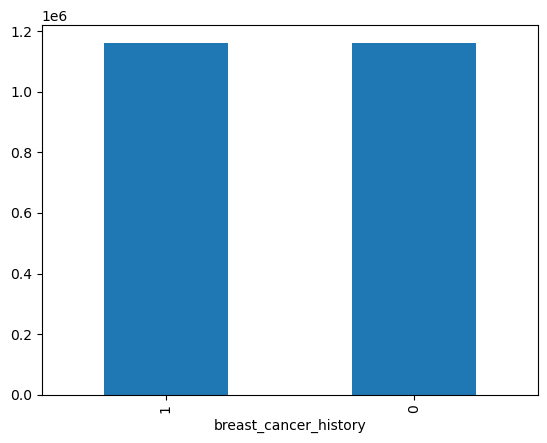

In [38]:
#since GMM doesn't have class_weight attribute, have to balance dataset first

# Identify the minority class
minority_class = df['breast_cancer_history'].value_counts().idxmin()
majority_class = df['breast_cancer_history'].value_counts().idxmax()

# Calculate how many samples to duplicate
samples_to_add = df['breast_cancer_history'].value_counts()[majority_class] - df['breast_cancer_history'].value_counts()[minority_class]

# Duplicate minority class samples
minority_samples = df[df['breast_cancer_history'] == minority_class].sample(n=samples_to_add, replace=True)

# Combine with the original dataset
balanced_df = pd.concat([df, minority_samples])

# Shuffle the dataset to mix the duplicated samples
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

#verify
balanced_df.breast_cancer_history.value_counts().plot(kind='bar')

In [39]:
balanced_df.columns

Index(['year', 'age_group_5_years', 'race_eth', 'first_degree_hx',
       'age_menarche', 'age_first_birth', 'BIRADS_breast_density',
       'current_hrt', 'menopaus', 'bmi_group', 'biophx',
       'breast_cancer_history'],
      dtype='object')

In [40]:
# split data into features (X) and labels (y)
#may need to drop biophx
X = balanced_df.iloc[:,0:11]
y = balanced_df.iloc[:,-1]

In [41]:
#standard scale since one col is years, some cols go from 0-13, some from 0-2, etc
scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)

X_scaled.sample(5)

,year,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx
206872,0.237076,0.880887,1.107102,-0.494172,-1.354305,1.429940,-0.668011,-0.132637,0.385143,-0.055800,1.092561
1321741,-0.318771,0.112481,-0.541542,-0.494172,0.122700,-0.796219,-0.668011,-0.132637,0.385143,0.913666,1.092561
1374540,-1.430464,-0.655924,-0.541542,2.023587,0.122700,1.429940,-0.668011,-0.132637,-1.449676,-1.025267,-0.915280
1699461,0.237076,-0.271722,-0.541542,-0.494172,1.599706,-1.538271,-0.668011,-0.132637,0.385143,-0.055800,-0.915280
1155111,-1.152541,-1.040127,-0.541542,-0.494172,1.599706,0.687887,1.993442,-0.132637,0.385143,-1.025267,1.092561


In [43]:
#gmm
nclusters=2 #since either 0 or 1
gmm = GaussianMixture(n_components=nclusters)
gmm.fit(X_scaled)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_scaled)
y_cluster_gmm


array([0, 0, 0, ..., 1, 0, 0])

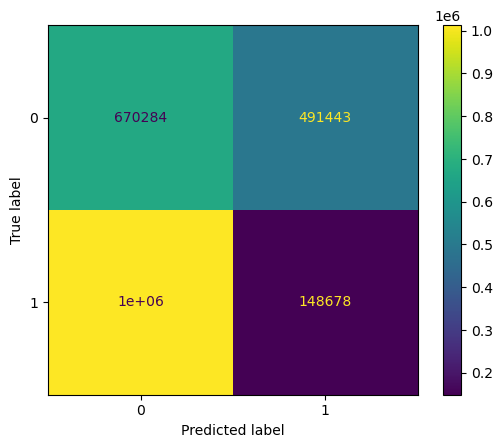

In [50]:
#confusion matrix

#gmm does not have attribute classes_ so have to add it in for matrix labels
cluster_to_class_map = {0: 0, 1: 1}
y_pred_labels = np.vectorize(cluster_to_class_map.get)(y_cluster_gmm)

#plot
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, y_pred_labels), display_labels=np.unique(y)).plot()


In [49]:
y_pred_labels

array(['No_ca', 'No_ca', 'No_ca', ..., 'Yes_ca', 'No_ca', 'No_ca'],
      dtype='<U6')